# Welcome to Data Science with Stardog

Press the Restart & Run All button to run all the cells in this notebook and view the output.

In [1]:
import io
import stardog as stardog
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Specify Stardog connection details

In [2]:
connection_details = {
  'endpoint': 'http://localhost:5820',
  'username': 'admin',
  'password': 'admin'
}

## Connect to the Stardog database

We already created the database from the command line. Now, we need to connect Python to it.

In [3]:
database_name = 'beachesDB'

conn = stardog.Connection(database_name, **connection_details)


<img src="toronto_beaches_2.png" width=1300 height=495 />

The Toronto area beaches are located along the north shore of Lake Ontario. The group flagged in orange are on Toronto Island. Rouge and Bluffer's Park are east of the center (Rouge being the furthest). Marie Curtis and Sunnyside are west of center. We can see if the data show any consistent differences between the beaches, and if E.coli seems to "travel" from one to another. Some people have suggested a relationship between E.coli and the weather, so we can check on that also.

## Query the database

This query selects every triple in the database, and then limits the output to 5.

In [4]:
query = """
SELECT * WHERE {
  ?s ?p ?o .
}
limit 5
"""

csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df


s  \
0  http://stardog.com/beaches/m-1   
1  http://stardog.com/beaches/m-2   
2  http://stardog.com/beaches/m-3   
3  http://stardog.com/beaches/m-4   
4  http://stardog.com/beaches/m-5   

                                                 p  \
0  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
1  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
2  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
3  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
4  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   

                                   o  
0  http://stardog.com/beaches/Sample  
1  http://stardog.com/beaches/Sample  
2  http://stardog.com/beaches/Sample  
3  http://stardog.com/beaches/Sample  
4  http://stardog.com/beaches/Sample

In these lines, the first 5 Sample classes are being defined.

`sparql` has a count function similar to SQL. Let's get the total number of triples in the database. This number will be significantly larger than the number of rows in the original CSV. Think of RDF as an extreme long form of the data.

In [5]:
query = """
SELECT (COUNT(*) AS ?n) WHERE {
  ?s ?p ?o .
}

"""

csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df

n
0  58665

## Data Exploration

I should have the same number of E.coli measurements on every beach. Let's check if that is true with a query that counts the number of measurements per beach. Unpacking this query, it instructs Stardog to:

* Find all triples (subject - predicate - object), where the predicate is beach:atBeach. 
* Insist that the objects be of class `beach:Beach`. Note that this is redundant in this example. The predicate beach:atBeach always leads to a `Beach`, but I like to be careful.
* also give me the label of the beach
* Now count the number of triples within each beach. Every new measurement on a particular beach, say *Rouge Beach*, contributes a triple of the form `something beach:atBeach "Rouge Beach"`. Counting over these triples gives the count that we want.
* Return the beach label, the beach id and the count
* Order alphabetically by label



In [6]:
query = """
prefix : <http://stardog.com/>
prefix weather: <http://stardog.com/weather/>
prefix tm: <http://stardog.com/time/>
prefix beach: <http://stardog.com/beaches/>

select ?name ?b (count(?b) as ?n) {
    ?s beach:atBeach ?b .
    ?b a beach:Beach ;
       rdfs:label ?name .
}
group by ?name ?b
order by ?name
"""

csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df

name                                b    n
0           Bluffer's Beach Park  http://stardog.com/beaches/b-10  645
1            Centre Island Beach   http://stardog.com/beaches/b-5  642
2                   Cherry Beach   http://stardog.com/beaches/b-7  646
3          Gibraltar Point Beach   http://stardog.com/beaches/b-4  642
4           Hanlan's Point Beach   http://stardog.com/beaches/b-3  644
5                Kew Balmy Beach   http://stardog.com/beaches/b-9  646
6   Marie Curtis Park East Beach   http://stardog.com/beaches/b-1  646
7                    Rouge Beach  http://stardog.com/beaches/b-11  646
8                Sunnyside Beach   http://stardog.com/beaches/b-2  647
9      Sunnyside Enclosure Beach  http://stardog.com/beaches/b-12  175
10           Ward's Island Beach   http://stardog.com/beaches/b-6  644
11              Woodbine Beaches   http://stardog.com/beaches/b-8  646

There are slight variations in the count, which suggests some missing values. And there is something going on with Sunnyside Enclosure. Perhaps that beach was not open throughout the study period. Let's check out what's happening with *Sunnyside Enclosure*.

* In this query, we limit the results to beaches with the literal name *Sunnyside Enclosure Beach*
* min and max are aggregating functions, like count. 
* You can see how the query "walks" the graph. ?s represents an E.Coli measurement unit (one row of the original CSV). I link to the beach and to the date entity. I pass from the date entity to the actual date string. I pass from the beach entity to its name. The name must be *Sunnyside Enclosure*. This connects *Sunnyside Enclosure* to its dates. Finally, I apply the min and max function to the date.

In [7]:
query = """
prefix weather: <http://stardog.com/weather/>
prefix tm: <http://stardog.com/time/>
prefix beach: <http://stardog.com/beaches/>

select (min(?day) as ?min_day) (max(?day) as ?max_day) {
    ?s beach:atBeach ?b ;
       tm:takenOn ?tm .
    ?b rdfs:label "Sunnyside Enclosure Beach" .
    
    ?tm tm:byDay ?day .
       
}

"""

csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df

min_day     max_day
0  2009-06-16  2011-06-05

It opened in 2009 and closed in early June of 2011. That explains why we have so few observations, compared to the other beaches.

### Missing Values

Graph databases do not have a missing value symbol as such, but we can query for paths that *should* exist if the data were complete. There's a lot to unpack here:

In the select statement, I want to see the beach name (?beach_name), the year and the number of missings. At the end of the query, you can see a `group by` statement, that will ensure we are counting over beaches and years. Then the results are ordered by name and by year within name.

I start with seeking the dates and beaches I *don't care about*, namely the ones where there is an E.Coli measurement. 

* The first clause pulls out the date information
* The second clause pulls out the beaches and their label
* If a beach has an E.coli measurement on a particular day, then there will be a path in the graph that links the day and the beach by way of a measurement entity. Symbol `/` tells the query to "find a path".
* Knowledge graphs are directional. `^beach:atBeach` says to follow that edge in reverse direction, i.e. from beach to sample. Then take whatever path you can find to connect to `tm:takenOn`.
* But what I want are those (?b ?day) pairs that are *not part of any path* that passes through an E.coli measurement. That's what `filter not exists` does.
* Finally, I group by beach and year, then order by year within beach.

In [8]:
query = """
prefix : <http://stardog.com/>
prefix weather: <http://stardog.com/weather/>
prefix tm: <http://stardog.com/time/>
prefix beach: <http://stardog.com/beaches/>


select  ?beach_name ?year (count(?day) as ?missings) {

    
    ?dt a tm:TimePoint ;
        tm:byDay ?day ;
        tm:byYear ?year .
    
    ?b a beach:Beach ;
       rdfs:label ?beach_name .
        
   
    filter not exists {
        ?b ^beach:atBeach/tm:takenOn/tm:byDay ?day
    }
    
}
group by ?beach_name ?year
order by ?beach_name ?year 



"""

csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df

beach_name  year  missings
0           Bluffer's Beach Park  2007         2
1            Centre Island Beach  2007         5
2                   Cherry Beach  2007         1
3          Gibraltar Point Beach  2007         5
4           Hanlan's Point Beach  2007         3
5                Kew Balmy Beach  2007         1
6   Marie Curtis Park East Beach  2007         1
7                    Rouge Beach  2007         1
8      Sunnyside Enclosure Beach  2007        92
9      Sunnyside Enclosure Beach  2008        91
10     Sunnyside Enclosure Beach  2009        17
11     Sunnyside Enclosure Beach  2011        91
12     Sunnyside Enclosure Beach  2012        90
13     Sunnyside Enclosure Beach  2013        91
14           Ward's Island Beach  2007         3
15              Woodbine Beaches  2007         1

We can see that Sunnyside is entirely missing for 2007 and 2008, when the beach was not open. But something's not right here. I have a scattering of missings in 2007, but after that, there are no missing values apart from Sunnyside Enclosure. Hmmm. Perhaps they dealt with missing values differently after that year. Some searching indicates that the status field can tell us something. I want to query to count the values of `status` by year.

In [9]:
query = """
prefix : <http://stardog.com/>
prefix weather: <http://stardog.com/weather/>
prefix tm: <http://stardog.com/time/>
prefix beach: <http://stardog.com/beaches/>

select ?year ?status (count(?s) as ?n)  {
    ?s a beach:Sample ;
        beach:status ?status ;
        tm:takenOn ?dt .
    
    ?dt a tm:TimePoint ;
    
        tm:byYear ?year .
    
}
group by ?year ?status
order by ?year ?status

"""

csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df

year    status    n
0   2007      SAFE  795
1   2007    UNSAFE  191
2   2007  UNTESTED    3
3   2008      SAFE  756
4   2008    UNSAFE  197
5   2008  UNTESTED   48
6   2009      SAFE  595
7   2009    UNSAFE  129
8   2009  UNTESTED  447
9   2010      SAFE  824
10  2010    UNSAFE  268
11  2010  UNTESTED   12
12  2011      SAFE  914
13  2011    UNSAFE   93
14  2011  UNTESTED    6
15  2012   NO_DATA   21
16  2012      SAFE  862
17  2012    UNSAFE  107
18  2013   NO_DATA    2
19  2013      SAFE  823
20  2013    UNSAFE  176

So that's it! There is a category of "untested", and starting in 2012, there is also a category for "no_data". Let's look at the E.coli values for those categories.

In [10]:
query = """

prefix : <http://stardog.com/>
prefix weather: <http://stardog.com/weather/>
prefix tm: <http://stardog.com/time/>
prefix beach: <http://stardog.com/beaches/>

select ?s ?ecoli ?status {
    ?s a beach:Sample ;
       beach:ecoli ?ecoli ;
       beach:status ?status .
    
    filter (?status = "UNTESTED")
}
limit 10

"""

csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df

s  ecoli    status
0   http://stardog.com/beaches/m-386   57.0  UNTESTED
1   http://stardog.com/beaches/m-387   45.0  UNTESTED
2   http://stardog.com/beaches/m-390   48.0  UNTESTED
3  http://stardog.com/beaches/m-2090    0.0  UNTESTED
4  http://stardog.com/beaches/m-2191    0.0  UNTESTED
5  http://stardog.com/beaches/m-2192    0.0  UNTESTED
6  http://stardog.com/beaches/m-2193    0.0  UNTESTED
7  http://stardog.com/beaches/m-2194    0.0  UNTESTED
8  http://stardog.com/beaches/m-2195    0.0  UNTESTED
9  http://stardog.com/beaches/m-2196    0.0  UNTESTED

So it looks as if they padded the E.coli results with zeroes when they failed to do the tests. This means we need to filter out those samples in further analyses, since we don't actually know that there were no traces of E.coli on those days. Examination of the "NO_DATA" status indicates that there was, in fact, no data on those days.


### Caveat

If data were missing for all of the beaches at once, these queries would possibly not pick up on that. We need to have TimePoint nodes created for every summer day within the study period, from 2007 through 2013. A TimePoint node is created the first time an E.coli measurement is taken on that day, or when a weather measurement is taken. 

To deal with the possibility that there might be a day where no beach was tested and no weather data (i.e. not summer 2011), I included TimePoint triples in the turtle file for every day of the study period. To learn more, see [blog post about mapping](Link to this post when I write it).

## Pattern of unsafe days

Let's plot the data and see what transpires. I will filter out the `UNTESTED` items and limit the analysis to 2011. And since E.coli measurements are highly skewed, I will take logs. The beach is deemed unsafe if the count goes above 100, so on a log scale, my cutoff is 2.0.

In [11]:
query = """

prefix : <http://stardog.com/>
prefix weather: <http://stardog.com/weather/>
prefix tm: <http://stardog.com/time/>
prefix beach: <http://stardog.com/beaches/>



select ?day ?beach (log10(?ecoli) as ?log_ecoli) ?status {
   ?x a beach:Sample ;
      beach:ecoli ?ecoli ;
      beach:status ?status ;
      beach:atBeach ?b;
      tm:takenOn ?dt .
   
   ?dt a tm:TimePoint ;
       tm:byDay ?day ;
       tm:byYear ?year .
   
   ?b a beach:Beach ;
      rdfs:label ?beach .
      
   # bind(log10(?ecoli + 1) as ?log_ecoli) .   

      
   filter (?status != "UNTESTED")
   filter(?year = 2011)
   
}
order by ?beach ?day

"""

csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df['day'] = pd.to_datetime(df['day']) # day came over as a string
#df.head()

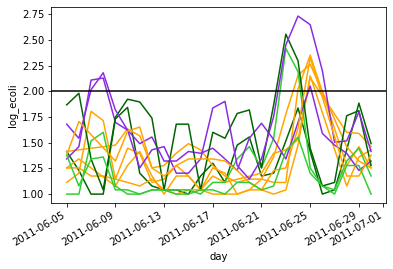

In [12]:
colors = ['darkgreen', 'orange', 'orange', 'orange', 'orange',
          'limegreen','blueviolet', 'darkgreen', 'blueviolet', 'orange', 'limegreen']
g = sns.lineplot(data=df[df['day'] < "2011-07-01"], x = "day", y = "log_ecoli", hue = "beach", 
                 legend = False, palette = colors)
g.axhline(2, color = "black")
g.figure.autofmt_xdate()

plt.show();

The counts are highly correlated, as one might expect. We can also see that the Toronto Island beaches form a distinct group, consistenly lower than the others, and possibly lagging by a day.

We can run a query to check on this. Let's rank the beaches by maximum E.coli count each year. Turns out, the same beachs are always in the top 5 -- except for 2013, which was a lot year.

In [13]:
query = """

prefix : <http://stardog.com/>
prefix weather: <http://stardog.com/weather/>
prefix tm: <http://stardog.com/time/>
prefix beach: <http://stardog.com/beaches/>


select ?beach ?year (max(?ecoli) as ?max_ecoli)    {

    ?x a beach:Sample ;
      beach:ecoli ?ecoli ;
      beach:atBeach ?b;
      tm:takenOn ?dt .
   
   ?dt a tm:TimePoint ;
       tm:byYear ?year .
   
   ?b a beach:Beach ;
      rdfs:label ?beach . 
      
    
}
group by ?beach ?year
order by ?year DESC (?max_ecoli) 


"""
csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df.head(n=10)

beach  year  max_ecoli
0               Kew Balmy Beach  2007     2121.0
1          Bluffer's Beach Park  2007     1595.0
2              Woodbine Beaches  2007     1515.0
3                   Rouge Beach  2007     1211.0
4  Marie Curtis Park East Beach  2007     1031.0
5               Sunnyside Beach  2007      798.0
6           Ward's Island Beach  2007      673.0
7           Centre Island Beach  2007      460.0
8                  Cherry Beach  2007      286.0
9         Gibraltar Point Beach  2007      165.0

## Pulling in the weather data

Now, let's look at E.coli counts together with the weather data. The weather data is hourly, so I need to match E.coli measurements to the daily average temperature, humidity and rainfall. This is usually a tedious merging task, but we have set up our DB to make this easy in Stardog.

In [14]:
query = """


prefix : <http://stardog.com/>
prefix weather: <http://stardog.com/weather/>
prefix tm: <http://stardog.com/time/>
prefix beach: <http://stardog.com/beaches/>

select ?beach_name ?day (avg(log10(?ecoli)) as ?log_ecoli) (avg(?ecoli) as ?ecoli_day) (avg(?temp) as ?temp_day) 
    (avg(?humidity) as ?humidity_day) (24*avg(?rain) as ?rainfall) (count(*) as ?n){
    ?s a weather:Sample ;
       tm:takenOn ?dt ;
       weather:hasTemp ?temp ;
       weather:hasHum ?humidity ;
       weather:hasRain ?rain .
    
    ?x a beach:Sample ;
      beach:ecoli ?ecoli ;
      beach:status ?status ;
      beach:atBeach ?b;
      tm:takenOn ?dt .
    
    ?b a beach:Beach ;
       rdfs:label ?beach_name .
     
   ?dt a tm:TimePoint ;
       tm:byDay ?day .
}
group by ?beach_name ?day 
order by ?beach_name ?day

"""

csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df.head()

beach_name  day  log_ecoli  ecoli_day  temp_day  humidity_day  rainfall  n
0         NaN  NaN          0          0         0             0         0  0

Note that there are 24 observations for each day and beach. This refers to the 24 hourly weather measurements. 

### Look at rainfall

The rainfall property measures the number of hours of rain on a given day. There is some research that suggests that rainfall can diminish e-coli count. We can check it out on a graph for a couple of beaches.

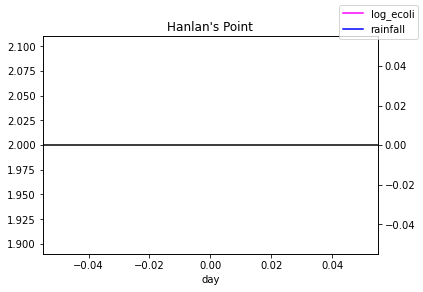

In [15]:


ax = df[df['beach_name'] == "Hanlan's Point Beach"].plot(x="day", y="log_ecoli", legend=False, color = "magenta")
plt.axhline(2, color = "black")
ax2 = ax.twinx()
df[df['beach_name'] == "Hanlan's Point Beach"].plot(x="day", y="rainfall", ax=ax2, legend=False, color="blue")
ax.figure.legend()
plt.title("Hanlan's Point")
plt.show()

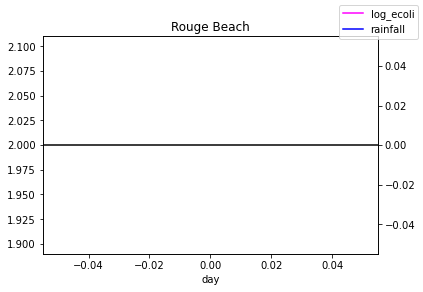

In [16]:


ax = df[df['beach_name'] == "Rouge Beach"].plot(x="day", y="log_ecoli", legend=False, color = "magenta")
plt.axhline(2, color = "black")
ax2 = ax.twinx()
df[df['beach_name'] == "Rouge Beach"].plot(x="day", y="rainfall", ax=ax2, legend=False, color="blue")
ax.figure.legend()
plt.title("Rouge Beach")
plt.show()

Some rainy days correspond to peeks in E.coli; others do not. Ah well! Maybe look at the temperature and humidity next?



## The Sampling feature

Stardog 7.9.0 has a fast sampling feature. It delivers an approximately random sample of the chosen entity. Each entity has approximately equal probability of being selected. Note the prefix line for the sampling service `<tag:stardog:api:sample>`. We probably wouldn't need to draw a sample in this situation, but to illustrate the new feature, this is how to draw 30 random E.coli measurements and display their associated beach name. Note that the order of the results is governed by the outer query with the beach name, so the sequence does not look random. However, the frequency of samples with respect to beaches is consistent with what you would expect from a simple random sample.

In [18]:
query = """
    prefix : <http://stardog.com/>
    prefix weather: <http://stardog.com/weather/>
    prefix tm: <http://stardog.com/time/>
    prefix beach: <http://stardog.com/beaches/>

    prefix smp: <tag:stardog:api:sample:>


    select ?beach_name ?ecoli {

          ?x beach:ecoli ?ecoli ;
             beach:atBeach ?b .

        ?b rdfs:label ?beach_name .

        service <tag:stardog:api:sample> {
              ?x a beach:Sample .
              [] smp:size 30 ;
        }
    }

"""

csv_results = conn.select(query, content_type='text/csv')
df = pd.read_csv(io.BytesIO(csv_results))
df.head()

beach_name  ecoli
0  Marie Curtis Park East Beach  426.0
1  Marie Curtis Park East Beach   67.0
2               Sunnyside Beach   15.0
3               Sunnyside Beach   48.0
4          Hanlan's Point Beach   11.0

## Finishing up

Having done some exploratory work, we can let Python take over the rest of the analysis. All that remains is to shut down the Stardog connection.

In [17]:
conn.__exit__()